<a href="https://colab.research.google.com/github/AishwaryaKalloli/andrejk/blob/main/micrograd_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
!pip install micrograd

In [3]:
from micrograd.engine import Value
from micrograd.nn import Neuron, Layer, MLP

In [4]:
np.random.seed(1337)
random.seed(1337)

(100, 2)


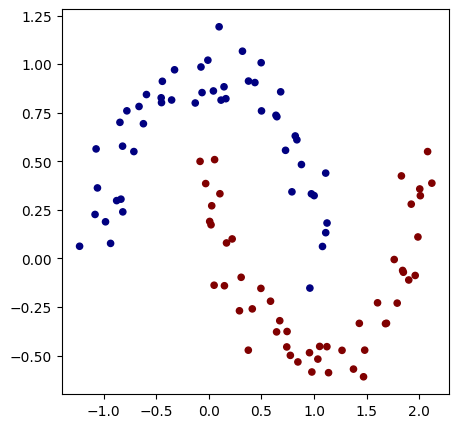

In [9]:
# make up a dataset
from sklearn.datasets import make_moons, make_blobs
X, y = make_moons(n_samples=100, noise=0.1)

# ys are 0 or 1s, convert them to -1 and 1s
y = y * 2 - 1
# visualise
plt.figure(figsize=(5, 5))
plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap='jet')

In [10]:
model = MLP(2, [16, 16, 1])
print(model)
print("number of parameters", len(model.parameters()))

MLP of [Layer of [ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2)], Layer of [ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16)], Layer of [LinearNeuron(16)]]
number of parameters 337


In [15]:
def loss(batch_size=None):

    # inline Dataloader
    if batch_size is None:
        Xb, yb = X, y
    else:
        # random index
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]

    inputs = [list(map(Value, xrow)) for xrow in Xb]

    scores = list(map(model, inputs))

    # loss
    losses = [(1 + -yi * scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))
    # L2 regularisation
    alpha = 1e-4
    reg_loss = alpha * sum((p * p for p in model.parameters()))
    total_loss = data_loss + reg_loss

    # accuracy
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(y, scores)]
    return total_loss, sum(accuracy) / len(accuracy)


total_loss, accuracy = loss()
print(total_loss, accuracy)

Value(data=0.9228910620425338, grad=0) 0.5


In [16]:
for k in range(100):
    total_loss, accuracy = loss()

    model.zero_grad()
    total_loss.backward()

    learning_rate = 1.0 - 0.9 * k / 100
    for p in model.parameters():
        p.data -= learning_rate * p.grad

    if k % 1 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {accuracy * 100}%")

step 0 loss 0.9228910620425338, accuracy 50.0%
step 1 loss 1.6903837845908336, accuracy 81.0%
step 2 loss 0.557520566854354, accuracy 81.0%
step 3 loss 0.5642457702641266, accuracy 83.0%
step 4 loss 0.3100292075376711, accuracy 86.0%
step 5 loss 0.27660578190885643, accuracy 85.0%
step 6 loss 0.30516560697604206, accuracy 89.0%
step 7 loss 0.2850917810809679, accuracy 86.0%
step 8 loss 0.2894944026136456, accuracy 90.0%
step 9 loss 0.25962662644579027, accuracy 90.0%
step 10 loss 0.25873283158942484, accuracy 90.0%
step 11 loss 0.22478752809025887, accuracy 91.0%
step 12 loss 0.3305542973908728, accuracy 91.0%
step 13 loss 0.38627164796690694, accuracy 84.0%
step 14 loss 0.322849383162428, accuracy 88.0%
step 15 loss 0.19837229635248319, accuracy 93.0%
step 16 loss 0.17302868267943702, accuracy 94.0%
step 17 loss 0.15059019719669314, accuracy 94.0%
step 18 loss 0.1404040458566761, accuracy 95.0%
step 19 loss 0.13460075682015613, accuracy 96.0%
step 20 loss 0.17510118421923168, accuracy

(-1.6086487731450796, 2.1413512268549204)

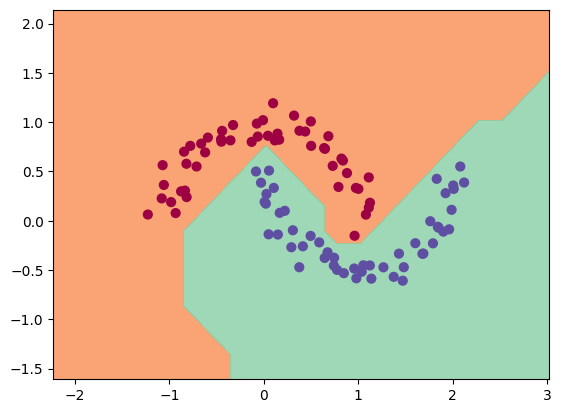

In [18]:
# Visualise decision boundary learned by the Neural Network
h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())